In [1]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

In [2]:
from utils.layers import Reshape, Flatten
import utils.datasets as d

In [3]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [4]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [5]:
X.shape

(83680, 160)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [7]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
#train = d.H_alphaSequences(X_train, y_train)
#test = d.H_alphaSequences(X_test, y_test)

In [10]:
class VariationalLayer(nn.Module):
    """
    Variational Layer with reparametrization trick. 
    It's used as bottleneck of Variational AutoEncoder ie. output of encoder.

    "Linear layer for variational inference with reparametrization trick"
    """
    def __init__(self, in_features, out_features, bias=True):
        """	
        : param in_features: 		Number of input features (number of neurons on input)
        : param out_features:		Number of output features (number of neurons on output)
        : param bias:				Include bias - True/False
        """
        super(VariationalLayer, self).__init__()
        self.mu = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        self.rho = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        self.softplus = nn.Softplus()

    def forward(self, x_in):
        mu = self.mu(x_in)
        sigma = self.softplus(self.rho(x_in))
        return mu, sigma

In [11]:
class ConvTransposeDecoderOutput(nn.Module):
    def __init__(self, in_channels, in_features, out_features, kernel_size, stride=1, padding=0, bias=True):
        super(ConvTransposeDecoderOutput, self).__init__()
        self.mu = nn.ConvTranspose1d(
                in_channels=in_channels, 
                out_channels=1, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
            )
        self.rho = nn.Linear(in_features=in_features, out_features=1, bias=bias)
        self.flatten = Flatten(out_features=in_features)
        self.flatten_mu = Flatten(out_features=out_features)
        self.softplus = nn.Softplus()

    def forward(self, x_in):
        """
        x must be shape ... (-1, in_channels, size)
        """
        mu = self.mu(x_in)
        x = self.flatten(x_in)
        sigma = self.softplus(self.rho(x))
        return self.flatten_mu(mu), sigma

In [12]:
encoder = nn.Sequential(
    Reshape(out_shape=(1, 160)),
    nn.Conv1d(in_channels=1, out_channels=16, kernel_size=6, stride=2, padding=0, bias=False), # n*1*160 -> n*16*78
    nn.PReLU(),
    nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, bias=False),#n*16*78->n*32*38
    nn.BatchNorm1d(num_features=32),
    nn.PReLU(),
    nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, bias=False),#n*32*38->n*64*18
    nn.BatchNorm1d(num_features=64),
    nn.PReLU(),
    Flatten(out_features=64*18),
    nn.Linear(in_features=64*18, out_features=256),
    nn.PReLU(),
    VariationalLayer(in_features=256, out_features=15)
    )


In [13]:
decoder = nn.Sequential(
    nn.Linear(in_features=15, out_features=256),
    nn.PReLU(),
    nn.Linear(in_features=256, out_features=64*18),
    Reshape(out_shape=(64,18)),
    nn.BatchNorm1d(num_features=64),
    nn.PReLU(),
    nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0),
    nn.BatchNorm1d(num_features=32),
    nn.PReLU(),
    nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=0),
    #nn.BatchNorm1d(num_features=16),
    nn.PReLU(),
    ConvTransposeDecoderOutput(
        in_channels=16, 
        in_features=16*78, 
        out_features=160, 
        kernel_size=6, 
        stride=2
        )
    )

In [14]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = encoder
        self.decoder = decoder
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            mu, sigma = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Normal(mu, sigma).to_event(1), obs=x)

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [15]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [16]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

# Training

In [17]:
# Run options
LEARNING_RATE = 1.0e-4
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 100
TEST_FREQUENCY = 5

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = torch.tensor(X_train).float(), batch_size=512, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset = torch.tensor(X_test).float(), batch_size=512, shuffle=True, pin_memory=True)

In [18]:
#train_loader, test_loader = setup_data_loaders(batch_size=512, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()


In [19]:
# setup the VAE
vae = VAE(z_dim=15, use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


In [20]:
train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 64.3545
[epoch 000] average test loss: -55.7593
[epoch 001]  average training loss: -82.0797
[epoch 002]  average training loss: -108.6903
[epoch 003]  average training loss: -129.6477
[epoch 004]  average training loss: -132.8624
[epoch 005]  average training loss: -142.4305
[epoch 005] average test loss: -153.4906
[epoch 006]  average training loss: -153.1037
[epoch 007]  average training loss: -151.5563
[epoch 008]  average training loss: -161.3264
[epoch 009]  average training loss: -156.4571
[epoch 010]  average training loss: -162.3662
[epoch 010] average test loss: -158.4549
[epoch 011]  average training loss: -162.7402
[epoch 012]  average training loss: -167.5902
[epoch 013]  average training loss: -177.0567
[epoch 014]  average training loss: -175.2875
[epoch 015]  average training loss: -175.7435
[epoch 015] average test loss: -184.0324
[epoch 016]  average training loss: -175.0882
[epoch 017]  average training loss: -181.4268
[epoch 018] 

In [28]:
total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
test_elbo.append(-total_epoch_loss_test)
print("[epoch %03d] average test loss: %.4f" % (100, total_epoch_loss_test))

[epoch 100] average test loss: -220.6867


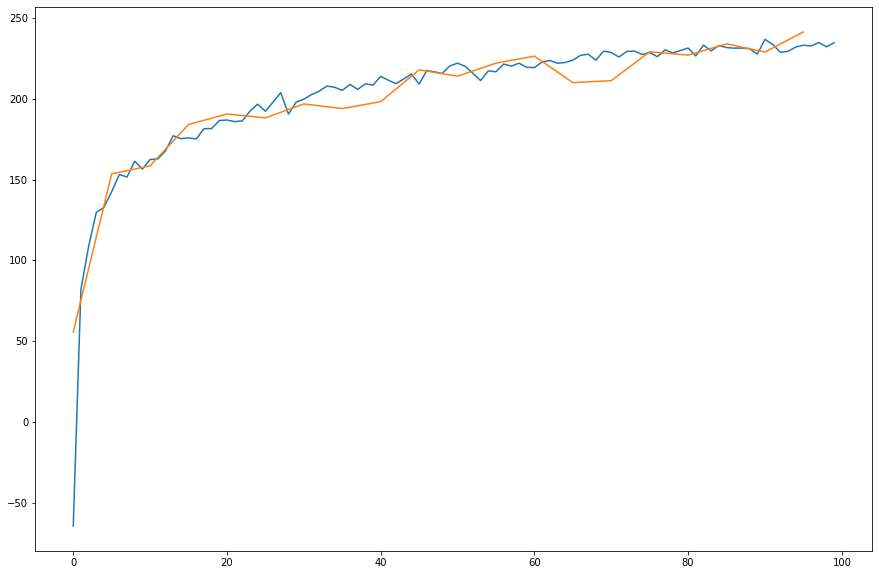

In [30]:
plt.figure(figsize=(15,10))
axe = np.arange(len(train_elbo))
plt.plot(axe, train_elbo)
plt.plot(axe[::5], test_elbo[:-1])
plt.show()

In [31]:
tmp = next(iter(test_loader))

In [32]:
tmp.shape

torch.Size([512, 160])

In [38]:
rec = vae.reconstruct_img(tmp.cuda())

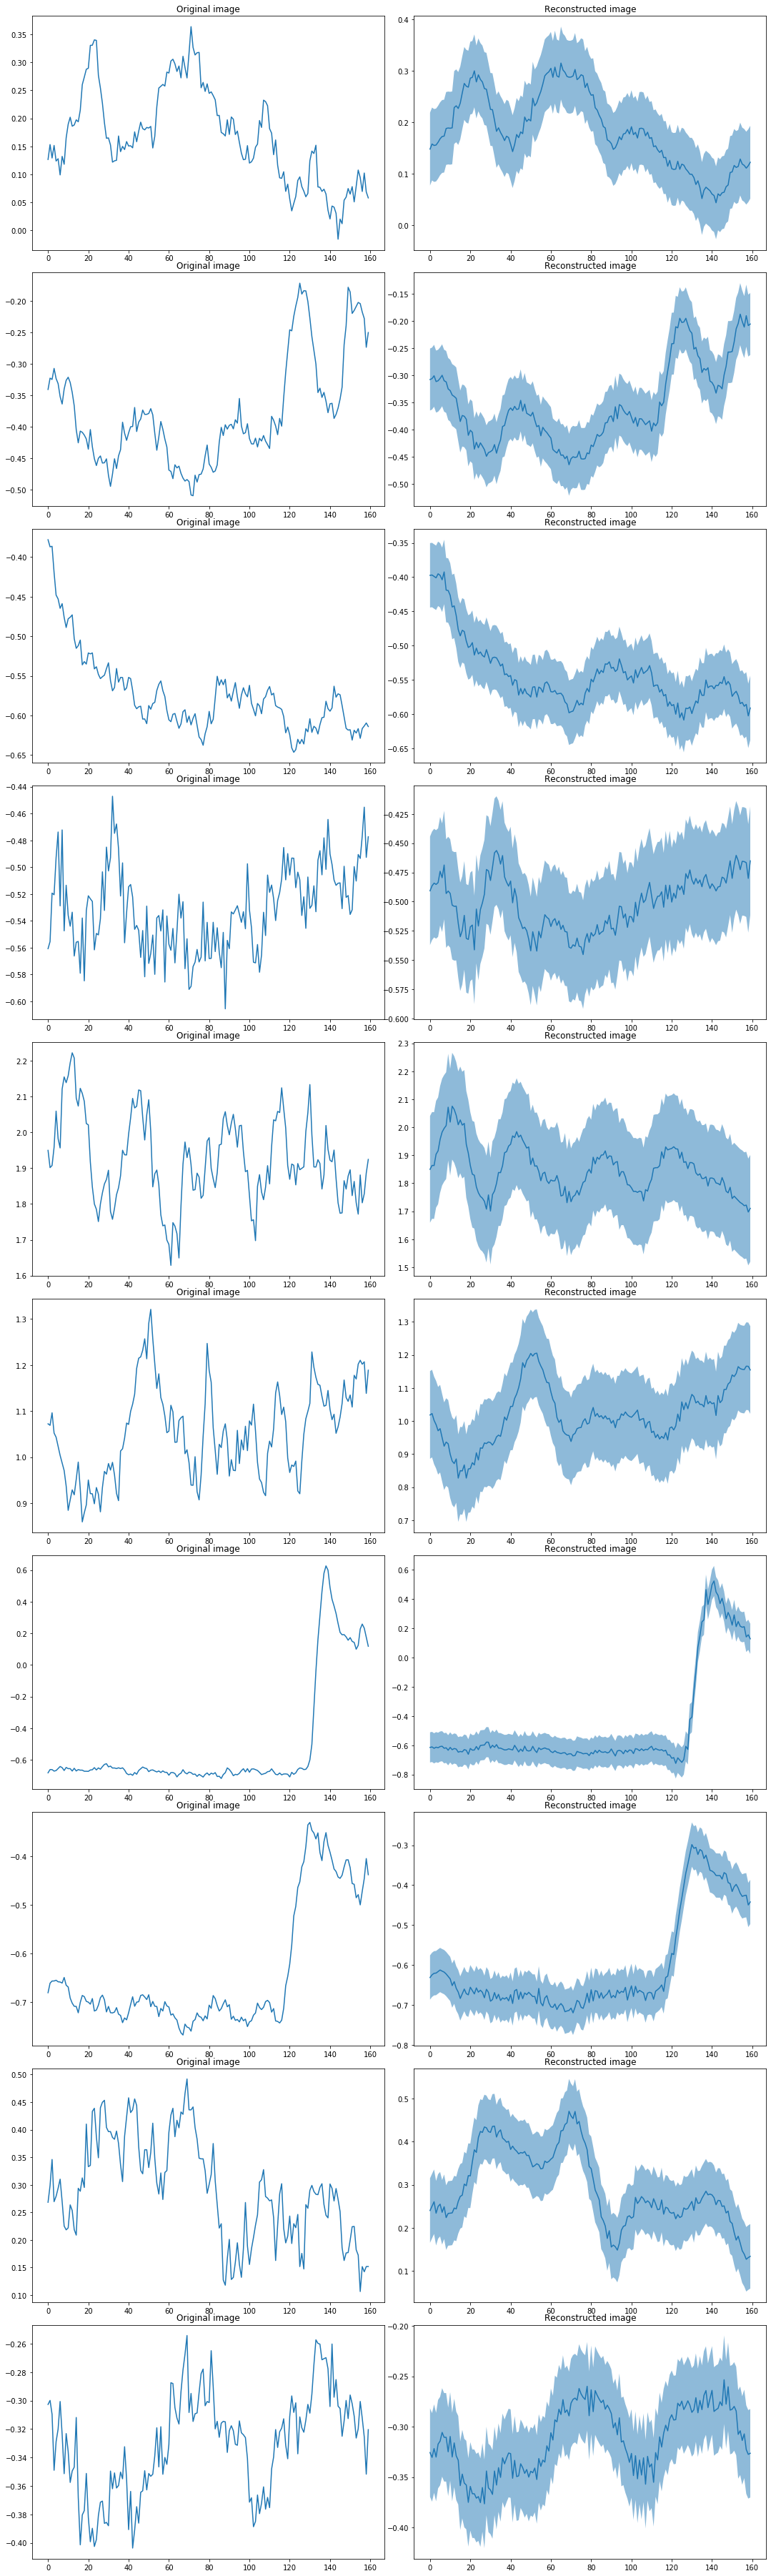

In [39]:
# epoch 100

#X_hat = output.cpu().detach().numpy()
mu_hat = rec[0].cpu().detach().numpy()
sigma = rec[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(tmp[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [42]:
vae.state_dict

<bound method Module.state_dict of VAE(
  (encoder): Sequential(
    (0): Reshape()
    (1): Conv1d(1, 16, kernel_size=(6,), stride=(2,), bias=False)
    (2): PReLU(num_parameters=1)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(2,), bias=False)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): Conv1d(32, 64, kernel_size=(4,), stride=(2,), bias=False)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=1)
    (9): Flatten()
    (10): Linear(in_features=1152, out_features=256, bias=True)
    (11): PReLU(num_parameters=1)
    (12): VariationalLayer(
      (mu): Linear(in_features=256, out_features=15, bias=True)
      (rho): Linear(in_features=256, out_features=15, bias=True)
      (softplus): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): PReLU(num_p

In [43]:
torch.save(vae, "models_and_losses/CVAE_with_pyro.pt")
torch.save(vae.state_dict,  "models_and_losses/CVAE_with_pyro_state_dict.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type VariationalLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ConvTransposeDecoderOutput. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [44]:
torch.save(vae.encoder, "models_and_losses/CVAE_with_pyro_encoder.pt")
torch.save(vae.encoder.state_dict, "models_and_losses/CVAE_with_pyro_encoder_state_dict.pt")

In [25]:
#rec = vae.decoder(torch.randn((100,50)).cuda())

In [26]:
#fig,ax = plt.subplots(10,10, figsize=(20,20))
#for i in range(10):
#    for j in range(10):
#        ax[i][j].imshow(rec[i*10+j].cpu().detach().numpy().reshape(28,28))
#        
#plt.show()